# Modelling and Evaluation

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, KFold, GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation
## Load & Clean Data
The pre-cleaned dataset was imported for further processing. Columns whose names contained the placeholder substring `"=<NA>"` were identified and removed,  
as they represented spurious dummy variables that had been automatically generated during the one-hot encoding stage when missing categorical values were present. Rows where the target variable `diabetes` equaled *Prediabetes* were also excluded. This category contained very few observations compared to the *No* and *Diabetes* groups, posing a risk of model bias and unstable evaluation metrics. By removing this underrepresented class, the outcome variable is simplified into a binary classification problem (*No* vs *Diabetes*). Any remaining imbalance between these two classes will later be addressed through stratified cross-validation.

This cleaning stage ensures that the dataset includes only valid predictors and a well-defined binary target variable. By removing redundant columns and the sparse *Prediabetes* category, the data becomes more consistent, balanced, and suitable for subsequent feature engineering and model development.

In [3]:
# Load cleaned dataset, drop invalid columns, and filter rows with valid diabetes labels

df = pd.read_csv("cleaned_datasetB.csv")
na_cols = [c for c in df.columns if "=<NA>" in c]
df = df.drop(columns=na_cols)
df = df[df["diabetes"].isin(["No", "Diabetes"])].copy()

## Define Features & Target
The target variable was defined as `diabetes`, representing whether an individual has been diagnosed with diabetes. 
Numerical predictors were identified as all non-object columns excluding the target variable and any dummy-encoded binary indicators. 
Categorical predictors included `general_health`, `sex`, and `education`, which will later undergo one-hot encoding during preprocessing. 
The dataset was then divided into predictors (`X`) and the target variable (`y`) to prepare for model training.

This step ensures that the modeling process clearly distinguishes between input features and the output variable. 
By explicitly defining numerical and categorical attributes, subsequent preprocessing operations—such as scaling, encoding, and cross-validation—can be applied systematically and reproducibly.

In [4]:
# Define target variable, separate numeric and categorical features, and prepare X and y

target = "diabetes"
num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != target and not any(x in c for x in ["=0","=1"])]
cat_cols = ["general_health", "sex", "education"]
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=5310)

## Data Preprocessing Pipeline
A preprocessing pipeline was created using the `ColumnTransformer` to ensure that numerical and categorical features 
are transformed appropriately before model training. Numerical attributes (`num_cols`) were standardized using 
`StandardScaler` to normalize feature distributions and eliminate the influence of differing measurement scales. 
Categorical attributes (`cat_cols`) were encoded using `OneHotEncoder` with the parameter 
`handle_unknown='ignore'`, allowing the model to safely handle unseen categories in future data without raising errors. 
All remaining columns were retained in their original form using the `remainder='passthrough'` argument.

This preprocessing step standardizes the data representation and ensures that both numerical and categorical variables 
are converted into model-compatible formats. By integrating scaling and encoding within a unified transformation 
pipeline, data leakage is prevented and the same preprocessing logic can be consistently applied to both training 
and testing datasets.

In [5]:
# Select numeric columns (exclude target and transformed columns)
num_cols = [
    c for c in df.columns
    if df[c].dtype != 'object'
    and c != target
    and not any(keyword in c for keyword in ["=0", "=1", "transformed"])]

# Preprocess: scale numeric, one-hot encode categorical, keep others
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

## Cross-Validation
Stratified 10-Fold Cross-Validation strategy was adopted to ensure that each fold maintains the same class distribution as the overall dataset. The dataset is split into 10 folds of approximately equal size. In each iteration, 9 folds are used for training and 1 fold for validation. The `shuffle=True` parameter randomizes the data before splitting, improving the robustness of the evaluation. The `random_state=5310` ensures that the folds are generated consistently across different runs, supporting reproducibility. The stratified design preserves the original proportion of the target classes (No vs. Diabetes) in every fold. This provides a fair and reliable model performance estimate, particularly important for imbalanced datasets. By maintaining consistent class ratios across folds, it reduces sampling bias and ensures that both majority and minority classes are adequately represented in each training–validation split.

In [6]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5310)

# Modelling

## Logistic Regression
The preprocessor object standardizes numerical variables using `StandardScaler`
and one-hot encodes categorical variables via `OneHotEncoder`.
This ensures all predictors are scaled and encoded in a consistent, model-ready format.
The `RandomUnderSampler` balances class proportions by randomly reducing majority-class samples,
mitigating bias toward the dominant No class.
A `LogisticRegression` classifier is trained on the resampled data.
Logistic regression provides interpretable coefficients while performing effectively on linearly separable features.

In [7]:
# Logistic Regression pipeline: preprocess → undersample → train model

lr_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("downsample", RandomUnderSampler(random_state=5310)),
    ("model", LogisticRegression(penalty="l2", max_iter=2000))
])

# Define parameter grid (balanced tuning)
lr_param_grid = {
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs", "liblinear"]  # both support l2 and predict_proba
}

# Grid search with F1-macro scoring
lr_grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=lr_param_grid,
    scoring="f1_macro",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit model and display best results
lr_grid.fit(X_train, y_train)
print("Best Parameters (LR):", lr_grid.best_params_)
print("Best CV score (search metric):", lr_grid.best_score_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters (LR): {'model__C': 0.1, 'model__solver': 'liblinear'}
Best CV score (search metric): 0.6204805743707376


## Decision Tree  
A `DecisionTreeClassifier` is used within a pipeline combining preprocessing and random undersampling.  Numerical features are standardized with `StandardScaler`, and categorical variables are encoded  via `OneHotEncoder`. The `RandomUnderSampler` balances class proportions before training.  
A hyperparameter grid (≈192 combinations) tunes key parameters including `criterion`, `max_depth`,  `min_samples_split`, `min_samples_leaf`, `max_features`, and `ccp_alpha`.     `GridSearchCV` with 10-fold cross-validation and **F1-macro** scoring selects the best model, balancing interpretability and generalization.


In [8]:
# Decision Tree pipeline: preprocess → undersample → train model

dt_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("downsample", RandomUnderSampler(random_state=5310)),
    ("model", DecisionTreeClassifier(random_state=5310))
])

# Define balanced parameter grid (≈192 candidates)
dt_param_grid = {
    "model__criterion": ["gini", "entropy"],        # 2
    "model__max_depth": [5, 10, 15, None],          # 4
    "model__min_samples_split": [2, 5],             # 2
    "model__min_samples_leaf": [1, 2],              # 2
    "model__max_features": ["sqrt", "log2"],        # 2
    "model__ccp_alpha": [0.0, 0.0005, 0.001]        # 3
}
# Total candidates: 2 * 4 * 2 * 2 * 2 * 3 = 192

n_candidates = len(ParameterGrid(dt_param_grid))
print(f"DT grid size: {n_candidates} candidates; expected total fits = {n_candidates * cv.get_n_splits()}")

# Grid search with F1-macro scoring
dt_grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    scoring="f1_macro",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
# Fit model and display best parameters
dt_grid.fit(X_train, y_train)
print("Best Parameters (DT):", dt_grid.best_params_)
print("Best CV score (search metric):", dt_grid.best_score_)


DT grid size: 192 candidates; expected total fits = 1920
Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Parameters (DT): {'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV score (search metric): 0.6001484215787088


## Linear SVM  
A `LinearSVC` model is built within a pipeline combining data preprocessing and random undersampling. Numerical features are standardized via `StandardScaler`, and categorical variables are encoded with  `OneHotEncoder` for consistent scaling. The `RandomUnderSampler` mitigates class imbalance.  A grid search over the regularization parameter `C` ([0.01, 0.1, 1, 10]) is conducted using 10-fold cross-validation with **F1-macro** as the scoring metric.  After selecting the best `C`, the final model is calibrated with `CalibratedClassifierCV`  (sigmoid method) to improve probabilistic interpretability.


In [9]:
# Linear SVM pipeline and grid search (minimal change)
svm_linear = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("downsample", RandomUnderSampler(random_state=5310)),
    ("model", LinearSVC(max_iter=5000, random_state=5310))
])

# Define hyperparameter grid for C
svm_param_grid = {"model__C": [0.01, 0.1, 1, 10]}

# Grid search with F1-macro scoring
svm_grid = GridSearchCV(
    estimator=svm_linear,
    param_grid=svm_param_grid,
    scoring="f1_macro",  # minimal-change: keep teammate's metric for search
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# Fit model and display best results
svm_grid.fit(X_train, y_train)

print("Best Parameters for Linear SVM:", svm_grid.best_params_)
print("Best CV F1 Score:", svm_grid.best_score_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters for Linear SVM: {'model__C': 1}
Best CV F1 Score: 0.6186759373856495


In [10]:
# Build final SVM with best C from grid search
best_C = svm_grid.best_params_["model__C"]

# Define final SVM pipeline
final_svm = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("downsample", RandomUnderSampler(random_state=5310)),
    ("model", LinearSVC(C=best_C, max_iter=5000, random_state=5310))
])

# Calibrate SVM using sigmoid method for probability estimates
calibrated_svm = CalibratedClassifierCV(
    estimator=final_svm,
    cv=3,
    method="sigmoid"
)


## Model Interpretation  
For interpretability, each optimized model is refitted on the full dataset to identify the most influential predictors. The following tables present the top and bottom five features for each model, highlighting variables associated with higher or lower outcome risk.


In [11]:
### Table 1. Top and Bottom 5 Predictors (Logistic Regression)

# Refit best logistic regression on full data (for interpretation only)
best_lr_est = lr_grid.best_estimator_
best_lr_est.fit(X_train, y_train)

# Extract model and feature names
lr_clf = best_lr_est.named_steps["model"]
feat_names = best_lr_est.named_steps["preprocessor"].get_feature_names_out()

# Get coefficients and validate length
coefs = lr_clf.coef_.ravel()
if len(feat_names) != len(coefs):
    raise ValueError(f"Feature names ({len(feat_names)}) and coefficients ({len(coefs)}) length mismatch.")

# Create coefficient table with odds ratio
coef_df = pd.DataFrame({
    "Feature": feat_names,
    "Coefficient": coefs
})
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])
coef_df["Type"] = coef_df["Coefficient"].apply(lambda x: "Higher risk (coef > 0)" if x > 0 else "Protective (coef < 0)")

# Select top and bottom 5 predictors
coef_df = coef_df.sort_values("Coefficient", ascending=False).reset_index(drop=True)
top5 = coef_df.head(5)
bot5 = coef_df.tail(5)
table_lr = pd.concat([top5, bot5], ignore_index=True)[["Feature", "Coefficient", "Odds_Ratio", "Type"]].round(3)

# Display results
print("Table 1. Top and Bottom 5 Predictors (Logistic Regression)")
display(table_lr)


Table 1. Top and Bottom 5 Predictors (Logistic Regression)


,Feature,Coefficient,Odds_Ratio,Type
0,cat__general_health_Excellent,1.372,3.945,Higher risk (coef > 0)
1,remainder__chol_check=0,0.610,1.840,Higher risk (coef > 0)
2,cat__general_health_Very Good,0.590,1.803,Higher risk (coef > 0)
3,remainder__blood_pressure=0,0.518,1.678,Higher risk (coef > 0)
4,remainder__alcoholic=1,0.457,1.579,Higher risk (coef > 0)
5,remainder__blood_pressure=1,-0.444,0.642,Protective (coef < 0)
6,remainder__chol_check=1,-0.536,0.585,Protective (coef < 0)
7,num__chol_check_missing,-0.560,0.571,Protective (coef < 0)
8,cat__general_health_Fair,-0.750,0.472,Protective (coef < 0)
9,cat__general_health_Other,-0.973,0.378,Protective (coef < 0)


In [12]:
### Table 2. Top and Bottom 5 Features (Decision Tree)

# Refit best decision tree on full data (for interpretation only)
best_dt_est = dt_grid.best_estimator_
best_dt_est.fit(X_train, y_train)

# Extract model and feature names
tree_clf = best_dt_est.named_steps["model"]
feat_names = best_dt_est.named_steps["preprocessor"].get_feature_names_out()

# Retrieve feature importances
importances = getattr(tree_clf, "feature_importances_", None)
if importances is None:
    raise ValueError("DecisionTreeClassifier has no feature_importances_ attribute.")

# Create importance table
imp_df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False).reset_index(drop=True)

# Select top and bottom 5 features
top5_dt = imp_df.head(5).assign(Type="Higher contribution")
bot5_dt = imp_df.tail(5).assign(Type="Lower contribution")
table_dt = pd.concat([top5_dt, bot5_dt], ignore_index=True)[["Feature", "Importance", "Type"]].round(3)

# Display results
print("Table 2. Top and Bottom 5 Features (Decision Tree)")
display(table_dt)


Table 2. Top and Bottom 5 Features (Decision Tree)


,Feature,Importance,Type
0,remainder__bmi_transformed,0.206,Higher contribution
1,cat__general_health_Excellent,0.198,Higher contribution
2,remainder__blood_pressure=1,0.194,Higher contribution
3,num__age_imputed,0.152,Higher contribution
4,cat__general_health_Very Good,0.138,Higher contribution
5,cat__sex_Male,0.000,Lower contribution
6,cat__sex_Female,0.000,Lower contribution
7,num__alcoholic_missing,0.000,Lower contribution
8,cat__general_health_Unknown health,0.000,Lower contribution
9,num__chol_check_missing,0.000,Lower contribution


In [13]:
### Table 3. Top and Bottom 5 Features (Linear SVM)

# Refit final SVM on full data (for interpretation only)
final_svm.fit(X_train, y_train)

# Retrieve feature names from the preprocessor
num_features = final_svm.named_steps["preprocessor"].transformers_[0][2]
cat_encoder = final_svm.named_steps["preprocessor"].transformers_[1][1]
cat_feature_names = cat_encoder.get_feature_names_out(["general_health", "sex", "education"])

passthrough_features = final_svm.named_steps["preprocessor"].transformers_[-1][-1]

all_features = np.concatenate([num_features, cat_feature_names, passthrough_features])

# Extract coefficients
coef = final_svm.named_steps["model"].coef_.flatten()

print(f"Number of features from transformer: {len(all_features)}")
print(f"Number of coefficients from model: {len(coef)}")

# Build interpretation table if feature–coefficient lengths match
if len(all_features) == len(coef):
    coef_df = pd.DataFrame({
        "Feature": all_features,
        "Coefficient": coef
    })
    
    coef_df["Weight_Exp"] = np.exp(coef_df["Coefficient"])
    coef_df["Type"] = coef_df["Coefficient"].apply(
        lambda x: "Higher risk (coef > 0)" if x > 0 else "Protective (coef < 0)"
    )

    # Select top and bottom 5 features
    coef_df = coef_df.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
    
    top_positive = coef_df.head(5)
    top_negative = coef_df.tail(5)
    interpret_features = pd.concat([top_positive, top_negative], ignore_index=True)
    
    # Display final interpretation table
    print("Table 3. Top and Bottom 5 Features (Linear SVM)")
    display(interpret_features.round(3))
else:
    print("Error: feature and coefficient length mismatch.")


Number of features from transformer: 50
Number of coefficients from model: 50
Table 3. Top and Bottom 5 Features (Linear SVM)


,Feature,Coefficient,Weight_Exp,Type
0,chol_check=0,0.982,2.670,Higher risk (coef > 0)
1,blood_pressure=0,0.958,2.607,Higher risk (coef > 0)
2,alcoholic=1,0.925,2.522,Higher risk (coef > 0)
3,cholesterol=0,0.897,2.452,Higher risk (coef > 0)
4,heart_disease_attack=0,0.855,2.351,Higher risk (coef > 0)
5,blood_pressure_missing,-0.084,0.919,Protective (coef < 0)
6,general_health_Other,-0.118,0.889,Protective (coef < 0)
7,age_imputed,-0.141,0.868,Protective (coef < 0)
8,chol_check_missing,-0.218,0.804,Protective (coef < 0)
9,bmi_transformed,-7.516,0.001,Protective (coef < 0)


## Model Integration  
The tuned Logistic Regression, Decision Tree, and calibrated Linear SVM models are stored in a unified dictionary for consistent evaluation and comparison under the same cross-validation and scoring setup.

In [14]:
models = {
    "Logistic Regression": lr_grid.best_estimator_,
    "Decision Tree": dt_grid.best_estimator_,
    "SVM": calibrated_svm}

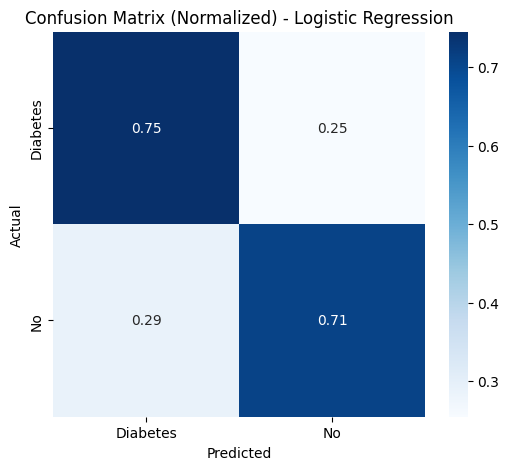

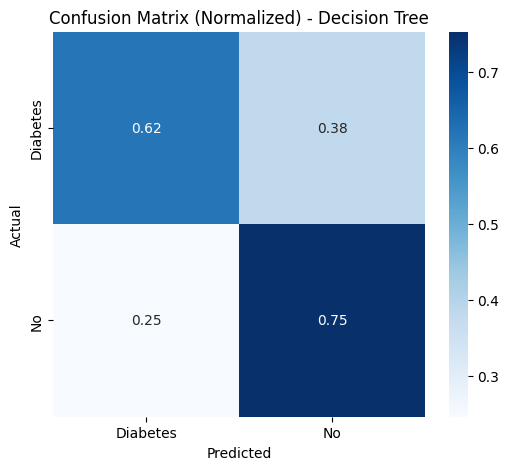

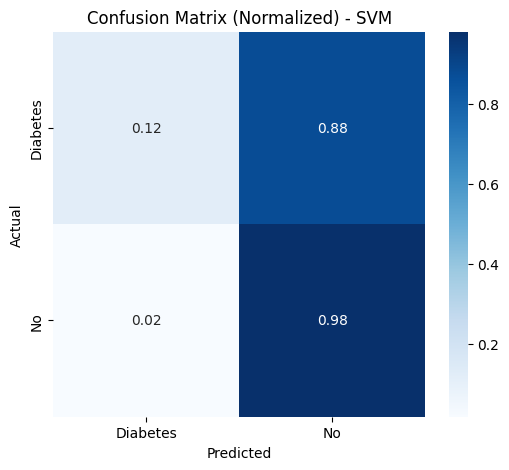

In [ ]:
# Evaluate the final selected models on the held-out test set using confusion matrices
for name, model in models.items():
    # 1. Fit the model using only the training data
    model.fit(X_train, y_train)
    # 2. Generate predictions on the unseen test set
    y_pred = model.predict(X_test)
    # 3. Compute the confusion matrix, normalized by true labels (row-wise)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    # 4. Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f",
                xticklabels=np.unique(y),
                yticklabels=np.unique(y))
    # 5. Add plot labels and formatting
    plt.title(f"Confusion Matrix (Test Set, Normalized) - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Model Evaluation and Comparison  
Each optimized model is evaluated using 10-fold cross-validation under identical conditions.  
Three metrics — **Accuracy**, **F1-macro**, and **ROC AUC (One-vs-Rest)** — are computed to capture  
overall correctness, class balance, and discrimination ability.  
The results are aggregated into a single summary table for direct performance comparison.


In [16]:
models = {
    "Logistic Regression": lr_grid.best_estimator_,
    "Decision Tree": dt_grid.best_estimator_,
    "SVM": calibrated_svm}

# Evaluate all models with cross-validation
final_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = None
    final_results.append([name, acc, f1m, auc])
# Create and display summary results table
final_df = pd.DataFrame(final_results, columns=["Model", "Test Accuracy", "Test Macro-F1", "Test ROC-AUC"])
display(final_df)

,Model,Test Accuracy,Test Macro-F1,Test ROC-AUC
0,Logistic Regression,0.715540,0.618935,0.798923
1,Decision Tree,0.733980,0.613474,0.743640
2,SVM,0.859171,0.559503,0.799283
